# Pseudotime analysis with Monocle 3

In this Colab notebook, we perform **end-to-end** pseudotime analysis with Monocle 3 on mouse neuronal cell types from the [10k Brain Cells from an E18 Mouse](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/neuron_10k_v3) dataset.

The analysis closely follows [Pseudotime analysis with Monocle 2](https://bustools.github.io/BUS_notebooks_R/monocle2.html) and [Monocle 3](https://bustools.github.io/BUS_notebooks_R/monocle3.html) written by Lambda Moses at Caltech. Pre-processing of the data is performed with [kallisto and bustools](https://www.kallistobus.tools/) via the [kb-python](https://pypi.org/project/kb-python/) wrapper.

To run Monocle 3 in Colab we adapted the [Monocle 3 on Colab Test Drive](https://colab.research.google.com/drive/1PVYS5eyVbDHmEBsKlkzjuN2rMCS9gGqW#scrollTo=BLdvsEdsMR87) notebook by John Tigue at Reconstrue.

This tutorial was compiled by Kyung Hoi (Joseph) Min at Caltech.


## Download and extract the data

The data is > 25G, but usually downloads within 30 minutes.

In [0]:
# wget http://s3-us-west-2.amazonaws.com/10x.files/samples/cell-exp/3.0.0/neuron_10k_v3/neuron_10k_v3_fastqs.tar
download.file("http://s3-us-west-2.amazonaws.com/10x.files/samples/cell-exp/3.0.0/neuron_10k_v3/neuron_10k_v3_fastqs.tar", destfile="neuron_10k_v3_fastqs.tar")

In [0]:
# tar -zf neuron_10k_v3_fastqs.tar
untar("neuron_10k_v3_fastqs.tar")

In [0]:
# ls neuron_10k_v3_fastqs
list.files("neuron_10k_v3_fastqs")

Warning message in value_fun(ev$value, ev$visible):
“restarting interrupted promise evaluation”

[1] "neuron_10k_v3_S1_L001_I1_001.fastq.gz"
[2] "neuron_10k_v3_S1_L001_R1_001.fastq.gz"
[3] "neuron_10k_v3_S1_L001_R2_001.fastq.gz"
[4] "neuron_10k_v3_S1_L002_I1_001.fastq.gz"
[5] "neuron_10k_v3_S1_L002_R1_001.fastq.gz"
[6] "neuron_10k_v3_S1_L002_R2_001.fastq.gz"

## Generate a count matrix with `kb-python`

### Install `kb-python`

In [0]:
system("pip3 install kb-python==0.24.4", intern=TRUE)

[1] "Collecting kb-python==0.24.4"                                                                                                                                              
 [2] "  Downloading https://files.pythonhosted.org/packages/62/c9/2e5b8fa2cd873a23ae1aeb128b33165d6a9387a2f56ea1fafec1d6d32477/kb_python-0.24.4-py3-none-any.whl (35.4MB)"       
 [3] "Collecting loompy>=3.0.6"                                                                                                                                                  
 [4] "  Downloading https://files.pythonhosted.org/packages/36/52/74ed37ae5988522fbf87b856c67c4f80700e6452410b4cd80498c5f416f9/loompy-3.0.6.tar.gz (41kB)"                       
 [5] "Collecting anndata>=0.6.22.post1"                                                                                                                                          
 [6] "  Downloading https://files.pythonhosted.org/packages/2b/72/87196c15f68d9865c31a43a10cf7c50bcbcedd5607d09f9aada0b3963103/anndata-0.6.22.post1-py3-none-any.whl (47kB)"     
 [7] "Requirement already satisfied: h5py in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python==0.24.4) (2.8.0)"                                             
 [8] "Requirement already satisfied: numpy in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python==0.24.4) (1.17.4)"                                           
 [9] "Requirement already satisfied: scipy in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python==0.24.4) (1.3.2)"                                            
[10] "Requirement already satisfied: setuptools in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python==0.24.4) (41.6.0)"                                      
[11] "Requirement already satisfied: numba in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python==0.24.4) (0.40.1)"                                           
[12] "Requirement already satisfied: click in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python==0.24.4) (7.0)"                                              
[13] "Collecting numpy-groupies"                                                                                                                                                 
[14] "  Downloading https://files.pythonhosted.org/packages/96/7a/2196465530e72084c6bb97cd49bf8ccdc83919cc94755727aa148effbc0f/numpy_groupies-0.9.9.tar.gz (43kB)"               
[15] "Requirement already satisfied: pandas>=0.23.0 in /usr/local/lib/python3.6/dist-packages (from anndata>=0.6.22.post1->kb-python==0.24.4) (0.25.3)"                          
[16] "Requirement already satisfied: natsort in /usr/local/lib/python3.6/dist-packages (from anndata>=0.6.22.post1->kb-python==0.24.4) (5.5.0)"                                  
[17] "Requirement already satisfied: six in /usr/local/lib/python3.6/dist-packages (from h5py->loompy>=3.0.6->kb-python==0.24.4) (1.12.0)"                                       
[18] "Requirement already satisfied: llvmlite>=0.25.0dev0 in /usr/local/lib/python3.6/dist-packages (from numba->loompy>=3.0.6->kb-python==0.24.4) (0.30.0)"                     
[19] "Requirement already satisfied: pytz>=2017.2 in /usr/local/lib/python3.6/dist-packages (from pandas>=0.23.0->anndata>=0.6.22.post1->kb-python==0.24.4) (2018.9)"            
[20] "Requirement already satisfied: python-dateutil>=2.6.1 in /usr/local/lib/python3.6/dist-packages (from pandas>=0.23.0->anndata>=0.6.22.post1->kb-python==0.24.4) (2.6.1)"   
[21] "Building wheels for collected packages: loompy, numpy-groupies"                                                                                                            
[22] "  Building wheel for loompy (setup.py): started"                                                                                                                           
[23] "  Building wheel for loompy (setup.py): finished with status 'done'"           

### Download a pre-built mouse transcriptome index

In [0]:
system("kb ref -d mouse -i index.idx -g t2g.txt", intern=TRUE)

character(0)

### Generate a count matrix

I could not find a way to get R's `system` function to print out live output to `stderr`, which is where `kb` outputs useful real-time information.

You can bypass parts of this step using checkpoint files (uncomment the second and third lines).

In [0]:
# Uncomment these lines if you want to download checkpoint files so that kb doesn't generate them from scratch.
# download.file("https://caltech.box.com/shared/static/0r9xfveal5tqv0zoqhmcmxw3z122lpge.tar", destfile="output.tar")
# untar("output.tar", exdir="output")
system(paste(
  "kb count -o output -i index.idx -g t2g.txt -x 10xv3 -t 2 -m 8G",
  "neuron_10k_v3_fastqs/neuron_10k_v3_S1_L002_R1_001.fastq.gz",
  "neuron_10k_v3_fastqs/neuron_10k_v3_S1_L002_R2_001.fastq.gz",
  "neuron_10k_v3_fastqs/neuron_10k_v3_S1_L001_R1_001.fastq.gz",
  "neuron_10k_v3_fastqs/neuron_10k_v3_S1_L001_R2_001.fastq.gz"
), intern=TRUE)

character(0)

## Install R Packages

Install Monocle 3, BUSpaRse, and singleR.

### Monocle 3

This part of the notebook was taken directly from [Monocle 3 on Colab Test Drive](https://colab.research.google.com/drive/1PVYS5eyVbDHmEBsKlkzjuN2rMCS9gGqW#scrollTo=BLdvsEdsMR87).

First, we install various dependency libraries.

In [0]:
# Need to add this repo, otherwise libgdal-dev will cause apt-get to return 100 b/c of a 404. See:
# https://mothergeo-py.readthedocs.io/en/latest/development/how-to/gdal-ubuntu-pkg.html#install-gdal-ogr
# https://github.com/datacarpentry/r-raster-vector-geospatial/issues/138#issue-313014296

system("add-apt-repository ppa:ubuntugis/ppa")
system("apt-get update -qq")
system("apt-get -qq -y install --fix-missing libudunits2-dev python-gdal gdal-bin libgdal-dev", intern=TRUE)
system("apt-get -y install --fix-missing libudunits2-dev python-gdal gdal-bin libgdal-dev", intern=TRUE)

[1] "(Reading database ... \r(Reading database ... 5%\r(Reading database ... 10%\r(Reading database ... 15%\r(Reading database ... 20%\r(Reading database ... 25%\r(Reading database ... 30%\r(Reading database ... 35%\r(Reading database ... 40%\r(Reading database ... 45%\r(Reading database ... 50%\r(Reading database ... 55%\r(Reading database ... 60%\r(Reading database ... 65%\r(Reading database ... 70%\r(Reading database ... 75%\r(Reading database ... 80%\r(Reading database ... 85%\r(Reading database ... 90%\r(Reading database ... 95%\r(Reading database ... 100%\r(Reading database ... 145605 files and directories currently installed.)\r"
  [2] "Preparing to unpack .../libzstd1_1.3.3+dfsg-2ubuntu1.1_amd64.deb ...\r"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
  [3] "Unpacking libzstd1:amd64 (1.3.3+dfsg-2ubuntu1.1) over (1.3.3+dfsg-2ubuntu1) ...\r"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
  [4] "Setting up libzstd1:amd64 (1.3.3+dfsg-2ubuntu1.1) ...\r"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
  [5] "Selecting previously unselected package libmysqlclient-dev.\r"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
  [6] "(Reading database ... \r(Reading database ... 5%\r(Reading database ... 10%\r(Reading database ... 15%\r(Reading database ... 20%\r(Reading database ... 25%\r(Reading database ... 30%\r(Reading database ... 35%\r(Reading database ... 40%\r(Reading database ... 45%\r(Reading database ... 50%\r(Reading database ... 55%\r(Reading database ... 60%\r(Reading database ... 65%\r(Reading database ... 70%\r(Reading database ... 75%\r(Reading database ... 80%\r(Reading database ... 85%\r(Reading database ... 90%\r(Reading database ... 95%\r(Reading database ... 100%\r(Reading database ... 145605 files and directories currently installed.)\r"
  [7] "Preparing to unpack .../00-libmysqlclient-dev_5.7.28-0ubuntu0.18.04.4_amd64.deb ...\r"                           

[1] "Reading package lists..."                                                       
 [2] "Building dependency tree..."                                                    
 [3] "Reading state information..."                                                   
 [4] "libudunits2-dev is already the newest version (2.2.26-1)."                      
 [5] "gdal-bin is already the newest version (2.4.0+dfsg-1~bionic0)."                 
 [6] "libgdal-dev is already the newest version (2.4.0+dfsg-1~bionic0)."              
 [7] "python-gdal is already the newest version (2.4.0+dfsg-1~bionic0)."              
 [8] "The following packages were automatically installed and are no longer required:"
 [9] "  libgeos-3.6.2 libnvidia-common-430 libproj12"                                 
[10] "Use 'apt autoremove' to remove them."                                           
[11] "0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded."

The stock Monocle 3 install instructions begin with installing Bioconductor.

In [0]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install()
# BiocManager::valid()

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)
Installing package(s) 'BiocVersion'
Old packages: 'digest', 'rlang', 'roxygen2', 'rprojroot', 'scales', 'selectr',
  'tidyverse', 'xtable'


The second step in the stock install instructions is to actually install Monocle 3. For whatever reason, Bioconductor needs to be explicitly told to install 8 packages that are needed.

This install is long and has no progress indicator.

In [0]:
# Test one at a time to find the problem

# [X]: "Boibase"
# [X]: "DelayedArray"
# [X]: "DelayedMatrixStats"
# [X]: "limma"
# [X]: "S4Vectors"
# [ ]: "SingleCellExperiment"
# [ ]: "SummarizedExperiment"))

options(install.packages.check.source = "yes")
# Problem child: BiocManager::install(c("SingleCellExperiment"))
BiocManager::install(c("GenomicRanges"))

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)
Installing package(s) 'GenomicRanges'
also installing the dependencies ‘bitops’, ‘RCurl’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘BiocGenerics’, ‘S4Vectors’, ‘IRanges’, ‘GenomeInfoDb’, ‘XVector’

Old packages: 'digest', 'rlang', 'roxygen2', 'rprojroot', 'scales', 'selectr',
  'tidyverse', 'xtable'


In [0]:
# Issue, devtools::install_github('cole-trapnell-lab/monocle3') will report:
#   Skipping 8 packages not available: Biobase, BiocGenerics, DelayedArray, DelayedMatrixStats, limma, S4Vectors, SingleCellExperiment, SummarizedExperiment
# So, explicitly installing these seemed to help:

BiocManager::install(c("Biobase", "DelayedArray", "DelayedMatrixStats", "limma", "S4Vectors", "SingleCellExperiment", "SummarizedExperiment"))

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)
Installing package(s) 'Biobase', 'DelayedArray', 'DelayedMatrixStats', 'limma',
  'S4Vectors', 'SingleCellExperiment', 'SummarizedExperiment'
also installing the dependencies ‘formatR’, ‘lambda.r’, ‘futile.options’, ‘futile.logger’, ‘snow’, ‘rhdf5’, ‘Rhdf5lib’, ‘matrixStats’, ‘BiocParallel’, ‘HDF5Array’

Warning message in download.file(url, destfile, method, mode = "wb", ...):
“URL 'https://cran.rstudio.com/src/contrib/matrixStats_0.55.0.tar.gz': status was 'Failure when receiving data from the peer'”

Error in download.file(url, destfile, method, mode = "wb", ...) : 
  cannot open URL 'https://cran.rstudio.com/src/contrib/matrixStats_0.55.0.tar.gz'


Warning message in download.packages(pkgs, destdir = tmpd, available = available, :
“download of package ‘matrixStats’ failed”Warning message in install.packages(...):
“installation of package ‘DelayedArray’ had non-zero exit status”Warning message in install.packages(...):
“installation of package ‘HDF5Array’ had non-zero exit status”Warning message in install.packages(...):
“installation of package ‘SummarizedExperiment’ had non-zero exit status”Warning message in install.packages(...):
“installation of package ‘DelayedMatrixStats’ had non-zero exit status”Warning message in install.packages(...):
“installation of package ‘SingleCellExperiment’ had non-zero exit status”Old packages: 'digest', 'rlang', 'roxygen2', 'rprojroot', 'scales', 'selectr',
  'tidyverse', 'xtable'


In [0]:
# TODO: note this is repeated later. This is here just for isolated testing.
BiocManager::install("batchelor")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)
Installing package(s) 'batchelor'
also installing the dependencies ‘beeswarm’, ‘vipor’, ‘gridExtra’, ‘RcppAnnoy’, ‘RcppHNSW’, ‘irlba’, ‘rsvd’, ‘matrixStats’, ‘HDF5Array’, ‘ggbeeswarm’, ‘viridis’, ‘SingleCellExperiment’, ‘SummarizedExperiment’, ‘BiocNeighbors’, ‘BiocSingular’, ‘DelayedArray’, ‘DelayedMatrixStats’, ‘scater’, ‘beachmat’

Old packages: 'digest', 'rlang', 'roxygen2', 'rprojroot', 'scales', 'selectr',
  'tidyverse', 'xtable'


Back to stock install step 2:

In [0]:
devtools::install_github('cole-trapnell-lab/monocle3')

leidenbase   (NA     -> c22a7d01f...) [GitHub]
ggrepel      (NA     -> 0.8.1       ) [CRAN]
grr          (NA     -> 0.9.5       ) [CRAN]
igraph       (NA     -> 1.2.4.1     ) [CRAN]
lmtest       (NA     -> 0.9-37      ) [CRAN]
Matrix.utils (NA     -> 0.9.7       ) [CRAN]
pbapply      (NA     -> 1.4-2       ) [CRAN]
pbmcapply    (NA     -> 1.5.0       ) [CRAN]
pheatmap     (NA     -> 1.0.12      ) [CRAN]
plotly       (NA     -> 4.9.1       ) [CRAN]
proxy        (NA     -> 0.4-23      ) [CRAN]
pscl         (NA     -> 1.5.2       ) [CRAN]
RANN         (NA     -> 2.6.1       ) [CRAN]
rsample      (NA     -> 0.0.5       ) [CRAN]
RhpcBLASctl  (NA     -> 0.18-205    ) [CRAN]
Rtsne        (NA     -> 0.15        ) [CRAN]
slam         (NA     -> 0.1-46      ) [CRAN]
spdep        (NA     -> 1.1-3       ) [CRAN]
speedglm     (NA     -> 0.3-2       ) [CRAN]
uwot         (NA     -> 0.1.4       ) [CRAN]
rlang        (0.4.1  -> 0.4.2       ) [CRAN]
digest       (0.6.22 -> 0.6.23      ) [CRAN]
scales  

Skipping 9 packages not available: Biobase, SingleCellExperiment, batchelor, BiocGenerics, DelayedArray, DelayedMatrixStats, limma, S4Vectors, SummarizedExperiment


igraph (NA -> 1.2.4.1) [CRAN]


Installing 1 packages: igraph
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


✔  checking for file ‘/tmp/RtmpDDwPeB/remotes7b1fdd471c/cole-trapnell-lab-leidenbase-c22a7d0/DESCRIPTION’
─  preparing ‘leidenbase’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories (517ms)
─  building ‘leidenbase_0.1.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing 51 packages: ggrepel, grr, igraph, lmtest, Matrix.utils, pbapply, pbmcapply, pheatmap, plotly, proxy, pscl, RANN, rsample, RhpcBLASctl, Rtsne, slam, spdep, speedglm, uwot, rlang, digest, scales, zoo, hexbin, data.table, furrr, xtable, sp, spData, sf, deldir, LearnBayes, coda, expm, gmodels, FNN, RSpectra, RcppParallel, RcppProgress, dqrng, farver, future, globals, listenv, classInt, units, e1071, gdata, gtools, RcppEigen, sitmo
Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Skipping install of 'leidenbase' from a github remote, the SHA1 (c22a7d01) has not changed since last install.
  Use `force = TRUE` to force installation


✔  checking for file ‘/tmp/RtmpDDwPeB/remotes7b3bf29b22/cole-trapnell-lab-monocle3-9becd94/DESCRIPTION’
─  preparing ‘monocle3’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘monocle3_0.2.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


And that's it. Their set up is simple, after tackling some Colab specific annoyances. Install is slow on Colab but c'est la vie. With more experience perhaps there is a way to streamline this (the author is not an experienced R developer).



### BUSpaRse

`BUSpaRse` is an R package to process BUS files. We will be using it to read in count matrix generated by `kb`.

In [0]:
# Install devtools if it's not already installed
if (!require(devtools)) {
  install.packages("devtools")
}
# These need to be installed separately.
BiocManager::install(c("GenomicAlignments", "plyranges"))

Loading required package: devtools
Loading required package: usethis
Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)
Installing package(s) 'GenomicAlignments', 'plyranges'
also installing the dependencies ‘Rhtslib’, ‘XML’, ‘Biostrings’, ‘Rsamtools’, ‘rtracklayer’

Old packages: 'digest', 'rlang', 'roxygen2', 'rprojroot', 'scales', 'selectr',
  'tidyverse', 'xtable'


In [0]:
# Install from GitHub
devtools::install_github("BUStools/BUSpaRse")

Annotatio... (NA -> 1.46.1     ) [CRAN]
Annotatio... (NA -> 1.8.0      ) [CRAN]
biomaRt      (NA -> 2.40.5     ) [CRAN]
BSgenome     (NA -> 1.52.0     ) [CRAN]
ensembldb    (NA -> 2.8.1      ) [CRAN]
GenomicFe... (NA -> 1.36.4     ) [CRAN]
RcppArmad... (NA -> 0.9.800.1.0) [CRAN]
RSQLite      (NA -> 2.1.2      ) [CRAN]
ProtGenerics (NA -> 1.16.0     ) [CRAN]
bit64        (NA -> 0.9-7      ) [CRAN]
blob         (NA -> 1.2.0      ) [CRAN]
bit          (NA -> 1.1-14     ) [CRAN]


Skipping 18 packages ahead of CRAN: Biostrings, GenomeInfoDb, GenomicRanges, plyranges, S4Vectors, BiocGenerics, Biobase, IRanges, XVector, rtracklayer, Rsamtools, GenomeInfoDbData, GenomicAlignments, zlibbioc, SummarizedExperiment, BiocParallel, Rhtslib, DelayedArray
Installing 12 packages: AnnotationDbi, AnnotationFilter, biomaRt, BSgenome, ensembldb, GenomicFeatures, RcppArmadillo, RSQLite, ProtGenerics, bit64, blob, bit
Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


✔  checking for file ‘/tmp/RtmpDDwPeB/remotes7b6e8f085b/BUStools-BUSpaRse-35b7744/DESCRIPTION’
─  preparing ‘BUSpaRse’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘BUSpaRse_0.99.25.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


### SingleR

We use `SingleR` to infer cell types by comparing gene expression profiles of individual cells to bulk RNA-seq data of purified known cell types.

In [0]:
BiocManager::install("SingleR")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)
Installing package(s) 'SingleR'
also installing the dependencies ‘interactiveDisplayBase’, ‘AnnotationHub’, ‘BiocFileCache’, ‘rappdirs’, ‘ExperimentHub’

Old packages: 'AnnotationDbi', 'AnnotationFilter', 'biomaRt', 'BSgenome',
  'BUSpaRse', 'ensembldb', 'GenomicFeatures', 'ProtGenerics', 'digest',
  'rlang', 'roxygen2', 'rprojroot', 'scales', 'selectr', 'tidyverse', 'xtable'


### DropletUtils

We will be using `DropletUtils` to filter out empty droplets.

In [0]:
BiocManager::install("DropletUtils")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)
Installing package(s) 'DropletUtils'
also installing the dependencies 'locfit', 'R.oo', 'R.methodsS3', 'edgeR', 'R.utils'

Old packages: 'AnnotationDbi', 'AnnotationFilter', 'biomaRt', 'BSgenome',
  'BUSpaRse', 'ensembldb', 'GenomicFeatures', 'ProtGenerics', 'digest',
  'rlang', 'roxygen2', 'rprojroot', 'scales', 'selectr', 'tidyverse', 'xtable'


## Preprocessing

Load the count matrix into R for analysis.

This part of the tutorial was taken from [Pseudotime analysis with Monocle 2](https://bustools.github.io/BUS_notebooks_R/monocle2.html) and [Monocle 3](https://bustools.github.io/BUS_notebooks_R/monocle3.html) with slight modifications.

In [0]:
# This package is installed for the D3 color palette.
install.packages("ggsci")

library(monocle3)
library(biomaRt)
library(BUSpaRse)
library(DropletUtils)
library(SingleR)
library(Matrix)
library(tidyverse)
library(ggsci)

In [0]:
tr2g <- read.table(file="t2g.txt", sep="\t", col.names=c("transcript", "gene", "gene_name"))
head(tr2g)

transcript,gene,gene_name
<fct>,<fct>,<fct>
ENSMUST00000193812.1,ENSMUSG00000102693.1,4933401J01Rik
ENSMUST00000082908.1,ENSMUSG00000064842.1,Gm26206
ENSMUST00000162897.1,ENSMUSG00000051951.5,Xkr4
ENSMUST00000159265.1,ENSMUSG00000051951.5,Xkr4
ENSMUST00000070533.4,ENSMUSG00000051951.5,Xkr4
ENSMUST00000192857.1,ENSMUSG00000102851.1,Gm18956


In [0]:
res_mat <- read_count_output("./output/counts_unfiltered", name = "cells_x_genes", tcc = FALSE)

### Remove empty droplets

In [0]:
dim(res_mat)

[1]   55421 1454234

The number of genes seems reasonable. The number of barcodes is way larger than the expected ~10k.

In [0]:
tot_counts <- Matrix::colSums(res_mat)
summary(tot_counts)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     1.00     1.00    65.93     2.00 52610.00 

The vast majority of “cells” have only no or just a few UMI detected. Those are empty droplets. 10x claims to have cell capture rate of up to 65%, but in practice, depending on how many cells are in fact loaded, the rate can be much lower. A commonly used method to estimate the number of empty droplets is barcode ranking knee and inflection points, as those are often assumed to represent transition between two components of a distribution. While more sophisticated methods exist (e.g. see [emptyDrops in DropletUtils](https://www.bioconductor.org/packages/devel/bioc/vignettes/DropletUtils/inst/doc/DropletUtils.html#detecting-empty-droplets)), for simplicity, we will use the barcode ranking method here. However, whichever way we go, we don’t have the ground truth.

In [0]:
# Compute barcode rank
bc_rank <- barcodeRanks(res_mat, lower = 1000)

In [0]:
# Remove genes that are not detected and empty droplets
mat_filtered <- res_mat[Matrix::rowSums(res_mat) > 0, tot_counts > metadata(bc_rank)$inflection]
dim(mat_filtered)

[1] 35414 10878

Now the number of cells is closer to expectation.

Row names are Ensembl gene IDs.

In [0]:
head(rownames(mat_filtered))

[1] "ENSMUSG00000102693.1" "ENSMUSG00000051951.5" "ENSMUSG00000102851.1"
[4] "ENSMUSG00000103377.1" "ENSMUSG00000104017.1" "ENSMUSG00000103025.1"

In [0]:
head(colnames(mat_filtered))

[1] "AAACCCACACGCGGTT" "AAACCCACAGCATACT" "AAACCCACATACCATG" "AAACCCAGTCGCACAC"
[5] "AAACCCAGTGCACATT" "AAACCCAGTGGTAATA"

### Cell type inference

Load the provided mouse bulk RNA-seq data

In [0]:
ref_use <- MouseRNAseqData()
rownames(ref_use) <- tr2g$gene[match(rownames(ref_use), tr2g$gene_name)]
ref_use <- ref_use[!is.na(rownames(ref_use)),]

Using temporary cache /tmp/RtmpDDwPeB/BiocFileCache
snapshotDate(): 2019-10-22
Using temporary cache /tmp/RtmpDDwPeB/BiocFileCache
see ?SingleR and browseVignettes('SingleR') for documentation
Using temporary cache /tmp/RtmpDDwPeB/BiocFileCache
Using temporary cache /tmp/RtmpDDwPeB/BiocFileCache
Using temporary cache /tmp/RtmpDDwPeB/BiocFileCache
loading from cache
Using temporary cache /tmp/RtmpDDwPeB/BiocFileCache
Using temporary cache /tmp/RtmpDDwPeB/BiocFileCache
Using temporary cache /tmp/RtmpDDwPeB/BiocFileCache
see ?SingleR and browseVignettes('SingleR') for documentation
Using temporary cache /tmp/RtmpDDwPeB/BiocFileCache
Using temporary cache /tmp/RtmpDDwPeB/BiocFileCache
Using temporary cache /tmp/RtmpDDwPeB/BiocFileCache
loading from cache
Using temporary cache /tmp/RtmpDDwPeB/BiocFileCache
Using temporary cache /tmp/RtmpDDwPeB/BiocFileCache
Using temporary cache /tmp/RtmpDDwPeB/BiocFileCache


Then SingleR will assign each cell a label based on Spearman correlation with known cell types from bulk RNA-seq. These are meanings of the acronyms:

* OPCs: Oligodendrocyte progenitor cells
* NPCs: Neural progenitor cells
* aNSCs: Active neural stem cells
* qNSCs: Quiescent neural stem cells

In [0]:
annot <- SingleR(mat_filtered, ref_use, ref_use$label.fine, method="single")

### Create a `cell_data_set` object

Since we will do differential expression and gene symbols are more human readable than Ensembl gene IDs, we will get the corresponding gene symbols from Ensembl.

In [0]:
gns <- tr2g_ensembl(species = "Mus musculus", use_gene_name = TRUE)[,c("gene", "gene_name")] %>% 
  distinct()

Querying biomart for transcript and gene IDs of Mus musculus


Just like how the `Seurat` workflow is centered around the `Seurat` object, Monocle 3 workflow is centered around the `cell_data_set` object. To create a `cell_data_set` object, we at least need the gene count matrix, and optionally need cell and gene metadata. Note that this is different from the `CellDataSet` object for Monocle 2. Cell metadata must have the column `cell`, for cell names or barcodes. Gene metadata must have the `id` column for gene ID (here Ensembl gene ID), and a column `gene_short_name`, for gene symbols, is recommended and is required for some functions. In addition, cell metadata must have cell names as row names and gene metadata must have gene IDs as gene names when initializing the `cell_data_set` object.

In [0]:
cell_meta <- data.frame(cell = colnames(mat_filtered),
                        cell_type = annot$labels[match(colnames(mat_filtered), rownames(annot))],
                        stringsAsFactors = FALSE)
rownames(cell_meta) <- colnames(mat_filtered)
gene_meta <- gns %>% 
  filter(gene %in% rownames(mat_filtered), !is.na(gene)) %>% 
  rename(id = gene, gene_short_name = gene_name)
rownames(gene_meta) <- gene_meta$id
gene_meta <- gene_meta[rownames(mat_filtered),]
cds <- new_cell_data_set(mat_filtered, cell_metadata = cell_meta, gene_metadata = gene_meta)

### Dimension reduction

Part of the analysis is quite similar to a basic Seurat analysis: beginning with data normalization, then PCA, and then clustering and non-linear dimension reduction. Here the preprocess_cds will log1p normalize (default, uses log2) the data and perform PCA (default) or LSI (latent semantic indexing).

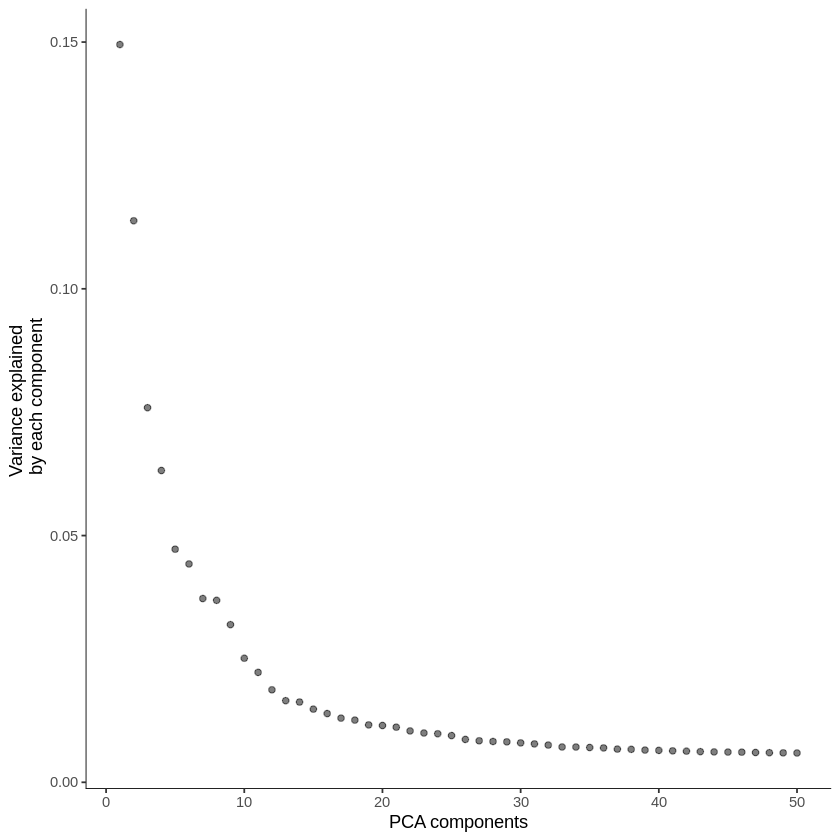

In [0]:
# Run PCA
cds <- preprocess_cds(cds, method = "PCA", num_dim = 50)
plot_pc_variance_explained(cds)

No trajectory to plot. Has learn_graph() been called yet?


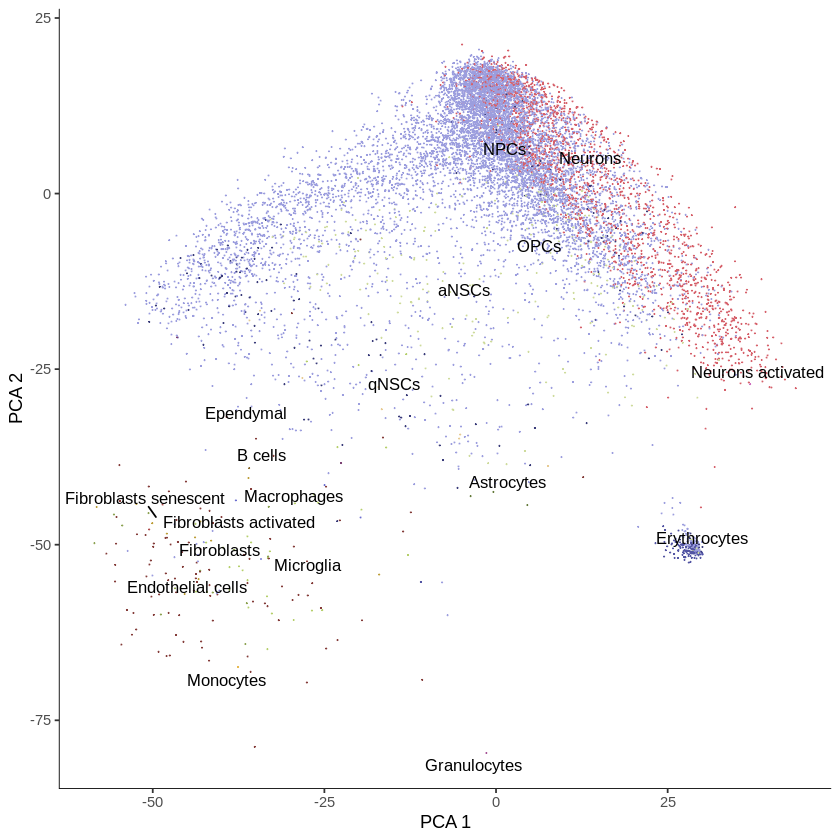

In [0]:
plot_cells(cds, reduction_method = "PCA",
           color_cells_by = "cell_type", group_label_size = 3.5,
           label_groups_by_cluster = FALSE) +
  scale_color_d3(palette = "category20b")

No trajectory to plot. Has learn_graph() been called yet?


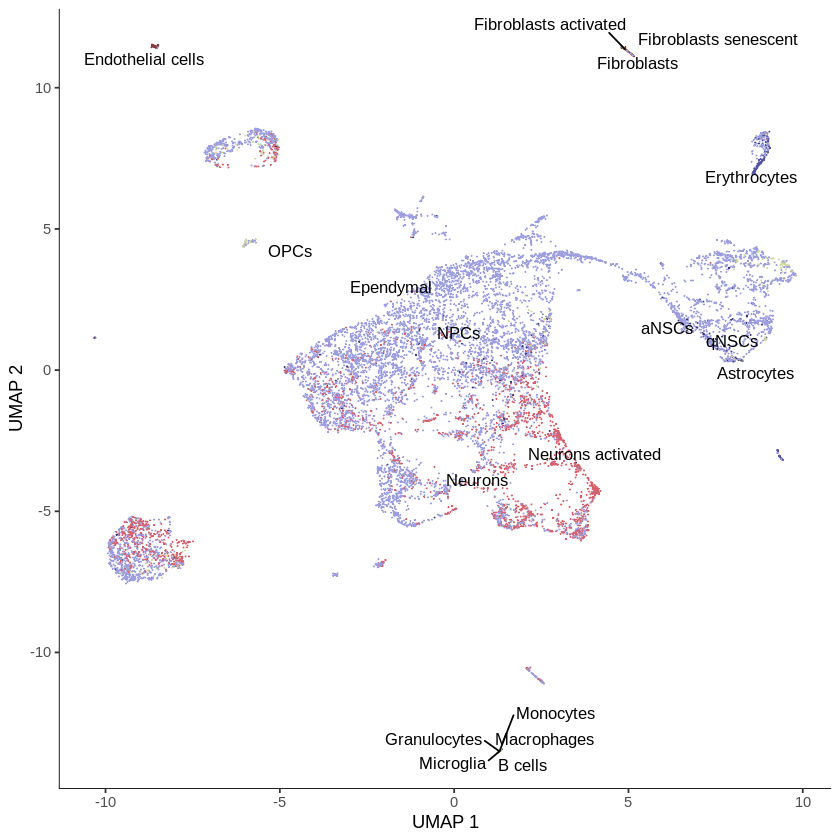

In [0]:
# Seed for random initiation of UMAP
set.seed(4837)
cds <- reduce_dimension(cds, reduction_method = "UMAP", preprocess_method = "PCA", init = "random")
plot_cells(cds, color_cells_by = "cell_type", group_label_size = 3.5,
           label_groups_by_cluster = FALSE) +
  scale_color_d3(palette = "category20b")

No trajectory to plot. Has learn_graph() been called yet?


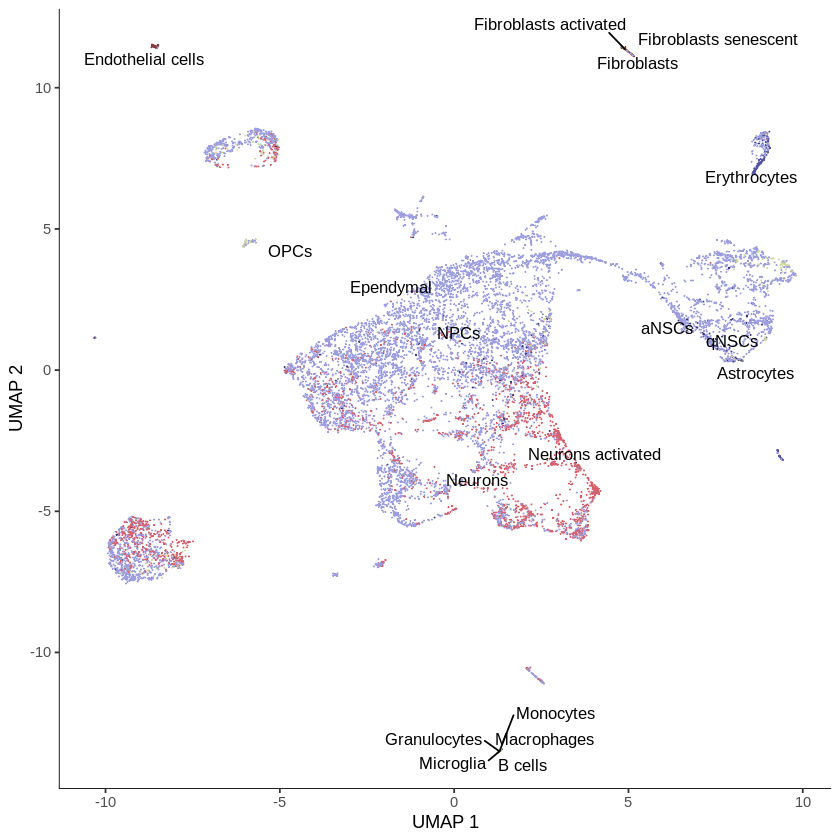

In [0]:
# Seed for random initiation of UMAP
set.seed(4837)
cds <- reduce_dimension(cds, reduction_method = "UMAP", preprocess_method = "PCA", init = "random")
plot_cells(cds, color_cells_by = "cell_type", group_label_size = 3.5,
           label_groups_by_cluster = FALSE) +
  scale_color_d3(palette = "category20b")

No trajectory to plot. Has learn_graph() been called yet?


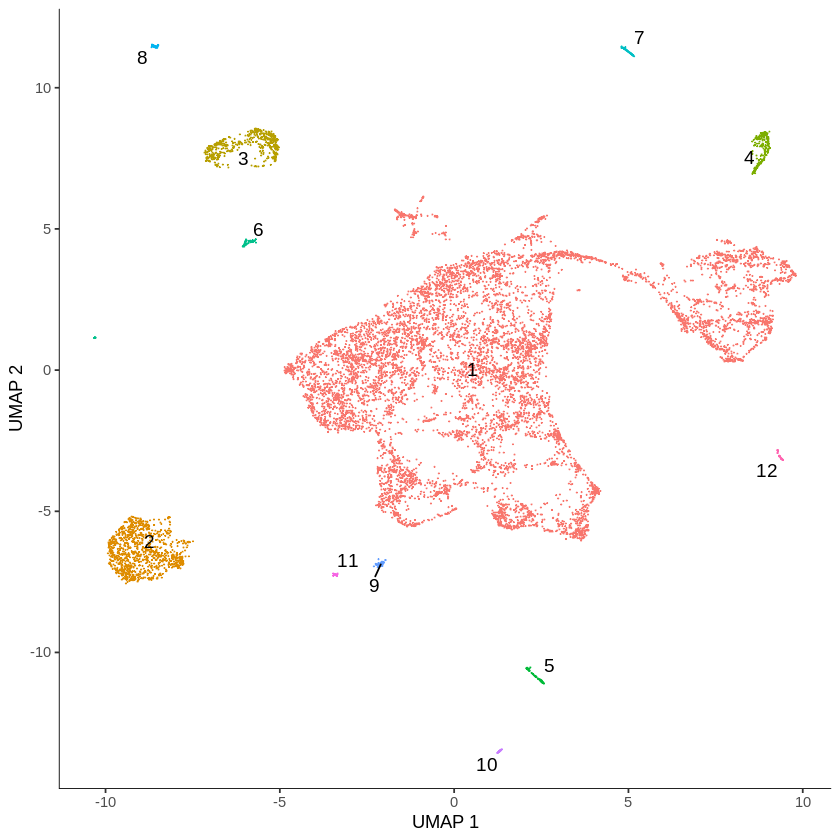

In [0]:
cds <- cluster_cells(cds)
plot_cells(cds, color_cells_by = "partition", group_cells_by = "partition", 
           group_label_size = 4)

No trajectory to plot. Has learn_graph() been called yet?


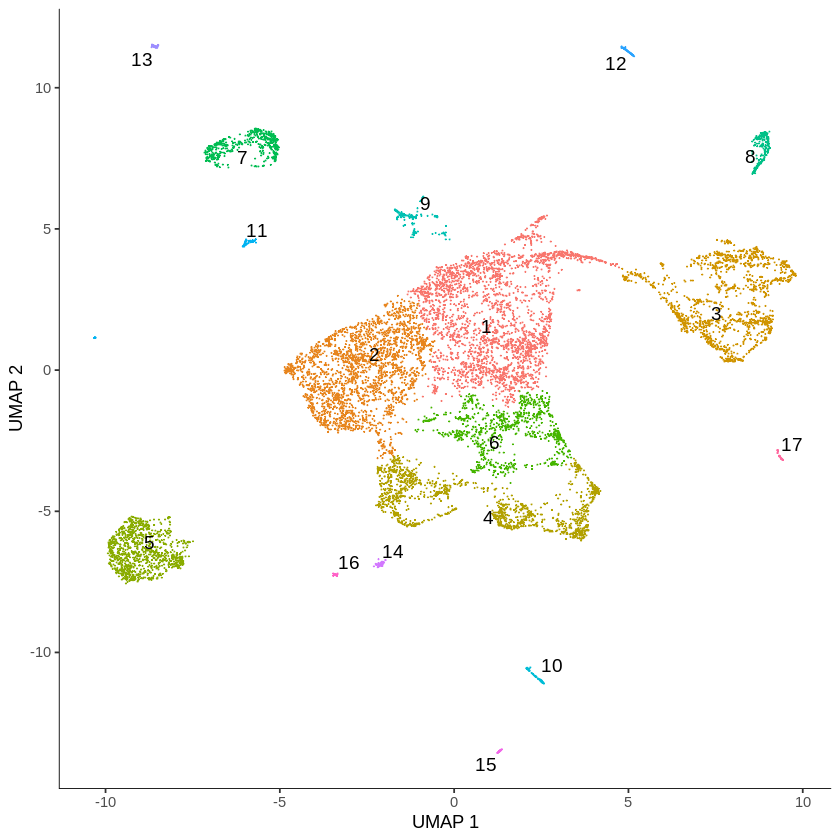

In [0]:
plot_cells(cds, color_cells_by = "cluster", group_cells_by = "cluster", 
           group_label_size = 4)

## Trajectory inference

Monocle 3’s trajectory inference is inspired by PAGA.

In [0]:
cds <- learn_graph(cds, verbose = FALSE, 
                   learn_graph_control = list(minimal_branch_len = 7,
                                              geodesic_distance_ratio = 0.5))

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


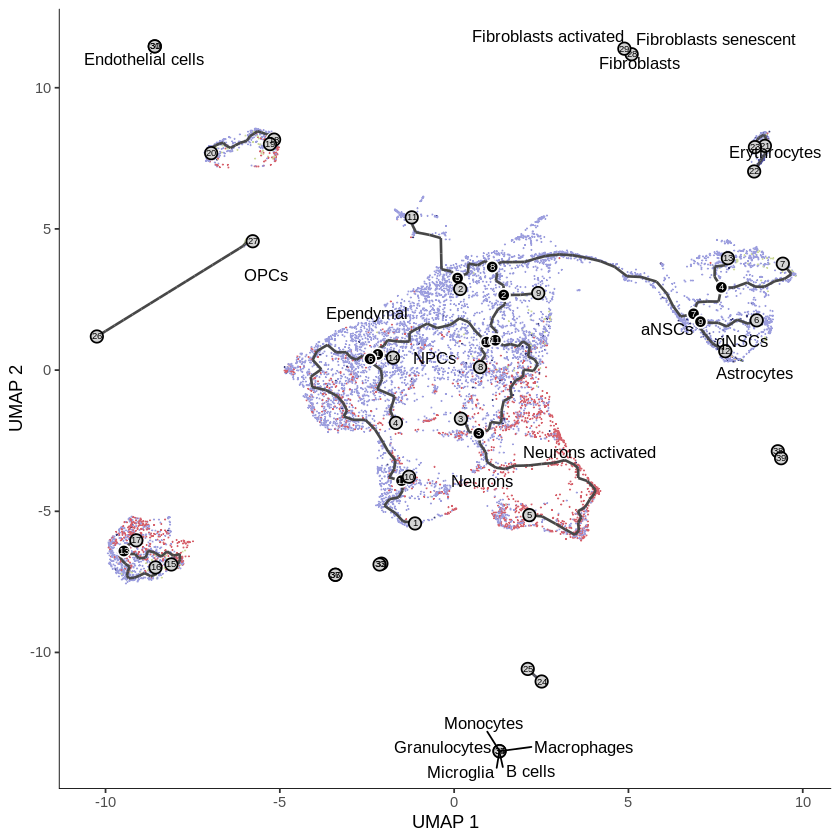

In [0]:
plot_cells(cds, color_cells_by = "cell_type", label_groups_by_cluster = FALSE,
           group_label_size = 3.5, graph_label_size = 2) +
  scale_color_d3(palette = "category20b")

The cells are not ordered on the graph. To compute pseudotime, we should supply a root node or a vector of root cells that we know are the earliest stage of the trajectory. The function `order_cells` can also open a shiny app to choose root node interactively.

Cells aren't colored in a way that allows them to be grouped.


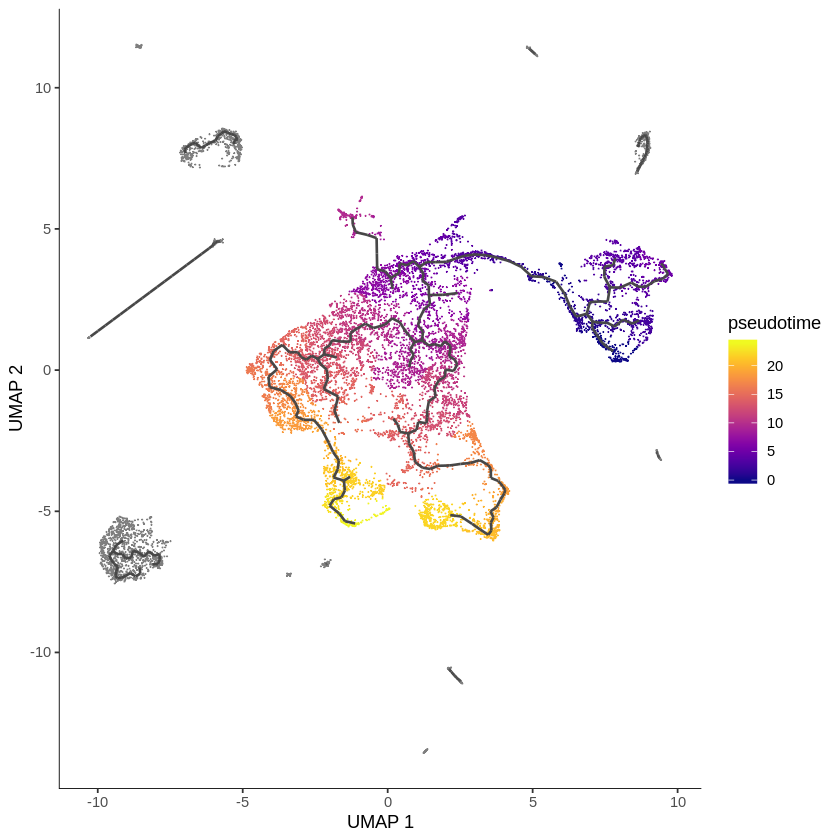

In [0]:
qnscs <- cell_meta$cell[cell_meta$cell_type == "qNSCs"]
cds <- order_cells(cds, root_cells = qnscs)
plot_cells(cds, color_cells_by = "pseudotime", label_branch_points = FALSE, label_leaves = FALSE, label_roots = FALSE)

For the trajectory for which pseudotime is computed, Monocle 3 can find genes differentially expressed along the trajectory.

Note that this step takes > 1 hour.

In [0]:
de_res <- graph_test(cds, neighbor_graph = "principal_graph", cores = 2)

Warning message:
"'rBind' is deprecated.
 Since R version 3.2.0, base's rbind() should work fine with S4 objects"

  |====================================================| 100%, Elapsed 01:24:57


These are some of the most significant genes differentially expressed along the trajectory.

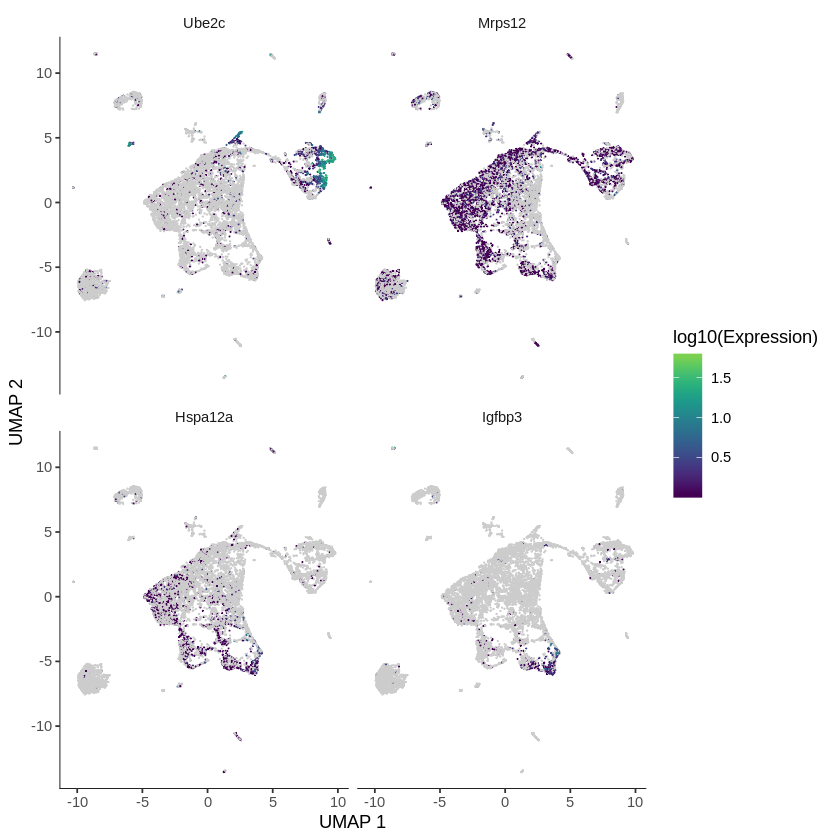

In [0]:
genes_plt <- c("Ube2c", "Mrps12", "Hspa12a", "Igfbp3")
plot_cells(cds, genes = genes_plt,
           show_trajectory_graph = FALSE,
           label_cell_groups = FALSE,
           label_leaves = FALSE)